In [4]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import torch
from transformers import AutoTokenizer, AutoModel



In [ ]:
#abstract text cleaning for upper case and delimeters
cleaned_abstracts = []
with open("/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt", "r", encoding="utf-8") as f:
    for line in f:
        
        parts = line.split("|--|")
        if len(parts) == 2:
            abstract_text = parts[1].strip()
        else:
            abstract_text = line.strip() 
        # 2) Convert to lowercase if using an uncased model
        abstract_text = abstract_text.lower()

        cleaned_abstracts.append(abstract_text)
    print(f"Abstract {1}:\n{abstract_text}\n")
    size=len(cleaned_abstracts)
    print(size)

In [ ]:
#DISTILIBERT CLS TOKEN EXTRACTION FROM OUR FINE-TUNED MODEL

#  list of ~138k cleaned abstracts
print(f"Total abstracts: {len(cleaned_abstracts)}")

#  fine-tuned model dir(not in this notebook)
model_dir = "/kaggle/working/distilbert-finetuned"

#  load tokenizer + model (base model, so we get hidden-states)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model     = AutoModel.from_pretrained(model_dir)

# GPU  check for faster extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

batch_size = 64
all_embeds = []

start = time.time()
for i in tqdm(range(0, len(cleaned_abstracts), batch_size), desc="Embedding"):
    batch = cleaned_abstracts[i : i + batch_size]
    
    # tokenize 
    inputs = tokenizer(batch,
                       return_tensors="pt",
                       padding=True,
                       truncation=True,
                       max_length=128).to(device)
    
    with torch.no_grad():
        out = model(**inputs)
    
    # CLS token is at position 0
    cls_emb = out.last_hidden_state[:, 0, :].cpu()  
    all_embeds.append(cls_emb)

# concat into one tensor
embeddings = torch.cat(all_embeds, dim=0)  # (138000, hidden_size)
end = time.time()

print(f"Done in {end-start:.1f}s — embeddings shape: {embeddings.shape}")

# save to disk (as NumPy .npy)
np.save("cls_embeddings.npy", embeddings.numpy())
print("Saved  cls_embeddings.npy")

In [ ]:
#SCIBERT CLS TOKEN EXTRACTION FROM ABSTRACTS


# model config
OUTPUT_PKL = 'scibert_embeddings.pkl'
PRETRAINED = 'allenai/scibert_scivocab_uncased' 

# tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
model     = AutoModel.from_pretrained(PRETRAINED)
model.eval()
if torch.cuda.is_available():
    model.to('cuda')


batch_size = 16
embeddings = {}  # paper_id -> vector
# cls token extraction
with torch.no_grad():
    for i in tqdm(range(0, len(cleaned_abstracts), batch_size), desc="Encoding abstracts"):
        batch_texts = abstracts[i : i + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        if torch.cuda.is_available():
            inputs = {k: v.to('cuda') for k, v in inputs.items()}

        outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        for idx, vec in enumerate(cls_emb, start=i):
            embeddings[idx] = vec

# Save to disk as pkl
with open(OUTPUT_PKL, 'wb') as f:
    pickle.dump(embeddings, f)

print(f" Saved {len(embeddings)} SciBERT embeddings to {OUTPUT_PKL}")

In [ ]:
!pip install node2vec

In [ ]:
#TUNED N2V RICH EMBEDDING EXTRACTION


# Paths & Config

EDGES_POS_PATH = "/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt"
OUTPUT_EMB = "node2vec_embeddings_train.pkl"
TEST_SIZE = 0.2
RNG_SEED = 42

# Limit threads for reproducibility
os.environ["OMP_NUM_THREADS"] = "2"


# 1. Load and split edges safely

print("📥 Loading positive edges...")
edges_pos = pd.read_csv(
    EDGES_POS_PATH,
    header=None,
    names=["u", "v"],
    dtype={"u": int, "v": int}
)
print(f"✅ {len(edges_pos)} positive edges loaded.")

# Combine with negatives solely to stratify-split 
# Here we split only positives for embedding training to avoid data-leakage
edges_train, edges_test = train_test_split(
    edges_pos,
    test_size=TEST_SIZE,
    random_state=RNG_SEED
)
edges_train = edges_train.reset_index(drop=True)
edges_test = edges_test.reset_index(drop=True)
print(f"📤 Split into {len(edges_train)} train and {len(edges_test)} test positive edges.")


# Build train-only graph

print(" Building train-only graph...")
G = nx.Graph()
G.add_edges_from(edges_train.values.tolist())
# Ensure all nodes appear (optional, for embedding coverage)
all_nodes = set(edges_pos.u) | set(edges_pos.v)
G.add_nodes_from(all_nodes)
print(f"✅ Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} train edges.")


# Train Node2Vec on train graph

print(" Training Node2Vec embeddings...")
start = time.time()
n2v = Node2Vec(
    graph=G,
    dimensions=128,
    walk_length=30,
    num_walks=30,
    workers=2,
    p=1, q=1,
    seed=RNG_SEED
)
model = n2v.fit(
    window=5,
    min_count=1,
    batch_words=10000
)
print(f" Node2Vec training completed in {time.time() - start:.2f}s.")


# Extract and save embeddings as pkl

print(" Extracting and saving embeddings...")
embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}
with open(OUTPUT_EMB, "wb") as f:
    pickle.dump(embeddings, f)
print(f" Saved embeddings for {len(embeddings)} nodes to '{OUTPUT_EMB}'.")

In [5]:
#FEATURE EXTRACTION FROM THE CITATION GRAPH



# Paths

EDGES_POS_PATH = "/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt"
GRAPH_FEAT_OUT = "graph_features.pkl"


#  Load positive edges

edges_pos = pd.read_csv(
    EDGES_POS_PATH,
    header=None,
    names=["u", "v"],
    dtype={"u": int, "v": int}
)
print(f"Loaded {len(edges_pos)} positive edges.")


#  Negative sampling (no overlap with any positives)

def sample_negatives(edges_pos: pd.DataFrame, rng_seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(rng_seed)
    pos_set = set(map(tuple, edges_pos.values))
    max_node = int(edges_pos.values.max()) + 1
    neg = set()
    while len(neg) < len(edges_pos):
        u, v = rng.integers(0, max_node, size=2)
        if u != v and (u, v) not in pos_set and (v, u) not in pos_set:
            neg.add((u, v))
    return pd.DataFrame(list(neg), columns=["u", "v"])

edges_neg = sample_negatives(edges_pos)
print(f"Sampled {len(edges_neg)} negative edges.")


# Combine & stratified train/test split

edges_pos["y"] = 1
edges_neg["y"] = 0
full_df = pd.concat([edges_pos, edges_neg], ignore_index=True)

train_df, test_df = train_test_split(
    full_df,
    test_size=0.2,
    random_state=42,
    stratify=full_df["y"]
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(f"Train pairs: {len(train_df)}, Test pairs: {len(test_df)}")


#  Build training graph (only train positives)

G = nx.Graph()
positives_train = train_df.loc[train_df.y == 1, ["u", "v"]].values
G.add_edges_from(positives_train)
print(f"Training graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

#  Define graph features (computed on G)


def compute_graph_features(G: nx.Graph, pairs: pd.DataFrame) -> dict:
    feat_dict = {}
    for u, v in tqdm(pairs[['u', 'v']].itertuples(index=False), total=len(pairs), desc="Computing graph features"):
        # Common neighbors count (log-scaled)
        try:
            cn = np.log1p(len(list(nx.common_neighbors(G, u, v))))
        except:
            cn = 0.0
        # Preferential attachment score (log-scaled)
        try:
            pa_raw = next((score for (_, _, score) in nx.preferential_attachment(G, [(u, v)])), 0)
            pa = np.log1p(pa_raw)
        except:
            pa = 0.0
        feat_dict[(u, v)] = np.array([cn, pa], dtype=np.float32)
    return feat_dict

# Compute features for both train and test pairs
graph_feat_train = compute_graph_features(G, train_df)
graph_feat_test  = compute_graph_features(G, test_df)

# Merge dicts
graph_feat_all = {**graph_feat_train, **graph_feat_test}


#  Save graph features

with open(GRAPH_FEAT_OUT, "wb") as f:
    pickle.dump(graph_feat_all, f)
print(f"Saved leakage-free graph features to '{GRAPH_FEAT_OUT}'")

Loaded 1091955 positive edges.
Sampled 1091955 negative edges.
Train pairs: 1747128, Test pairs: 436782
Training graph: 135417 nodes, 873564 edges.


Computing graph features:   0%|          | 0/1747128 [00:00<?, ?it/s]

Computing graph features:   0%|          | 0/436782 [00:00<?, ?it/s]

Saved leakage-free graph features to 'graph_features.pkl'


/tmp/ipykernel_35/4211229046.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


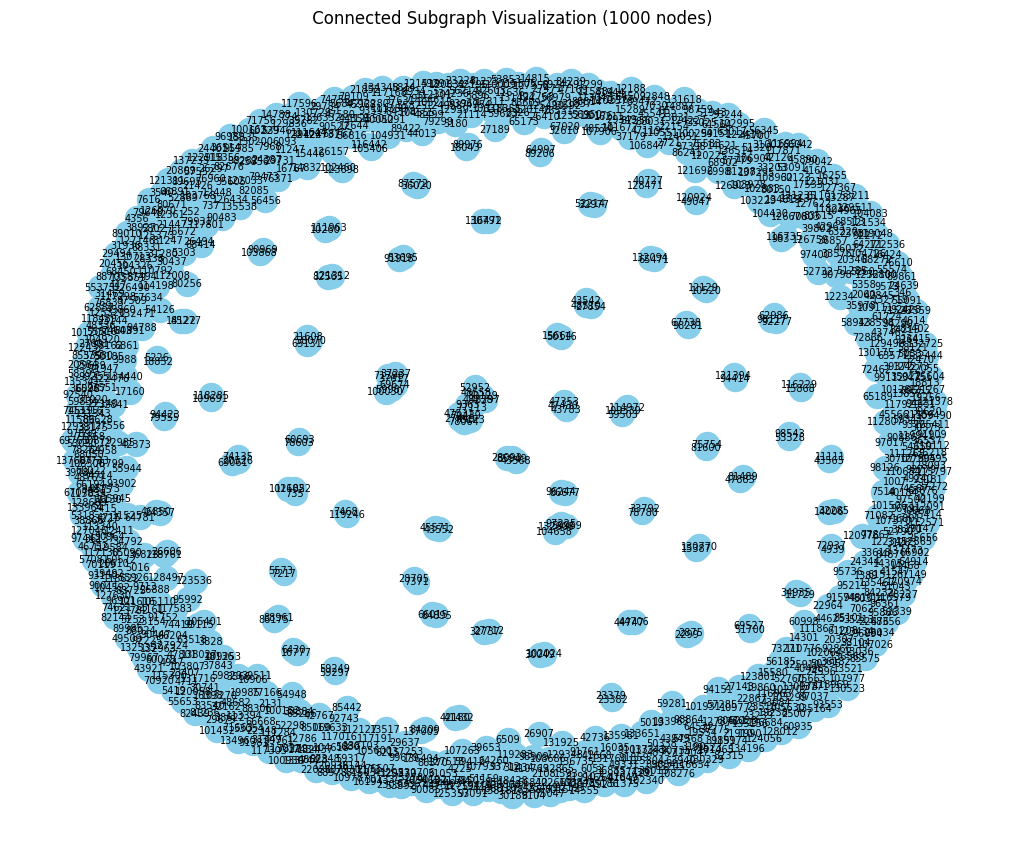

In [8]:
#PLOTTING FOR GRAPH FEATURES

# Load features (to get edge list)
with open("graph_features.pkl", "rb") as f:
    graph_feat_all = pickle.load(f)

# Build full graph from all feature keys
G_full = nx.Graph()
G_full.add_edges_from(graph_feat_all.keys())

# Find the largest connected component
largest_cc = max(nx.connected_components(G_full), key=len)
G_lcc = G_full.subgraph(largest_cc).copy()

# Sample 100 nodes from this connected component
sample_nodes = random.sample(list(G_lcc.nodes), 1000)

# Create the induced subgraph (still connected)
G_sample = G_lcc.subgraph(sample_nodes).copy()

# Layout and visualization
pos = nx.spring_layout(G_sample, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(
    G_sample, pos, with_labels=True, node_color="skyblue",
    edge_color="gray", node_size=300, font_size=7
)
plt.title(" Connected Subgraph Visualization (1000 nodes)")
plt.axis("off")
plt.tight_layout()
plt.show()

Common Neighbors:
  count = 2183910
  mean  = 0.480
  median= 0.000
  std   = 0.738

Preferential Attachment:
  count = 2183910
  mean  = 5.107
  median= 5.056
  std   = 2.241



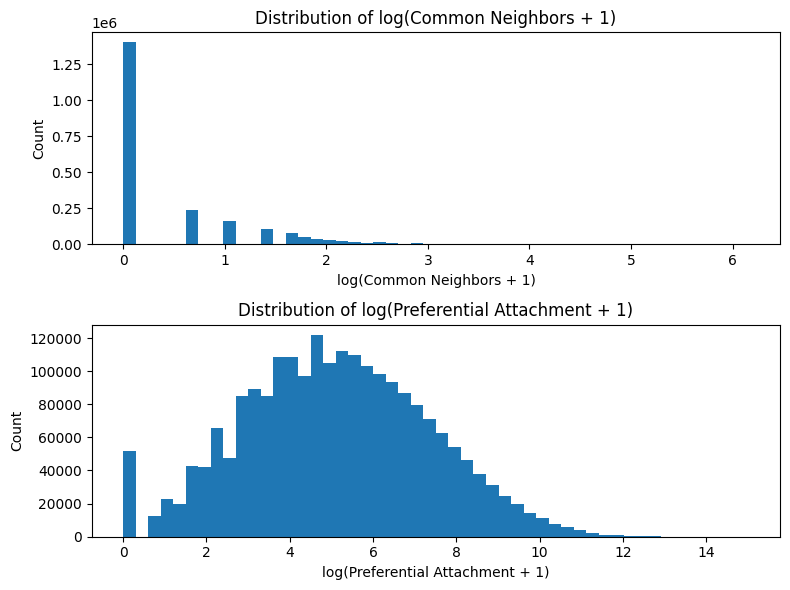

In [9]:

# Load  graph features dict
with open("graph_features.pkl", "rb") as f:
    graph_feat = pickle.load(f)

# Stack into arrays
data = np.stack(list(graph_feat.values()), axis=0)
cn = data[:, 0]   # log(common neighbors + 1)
pa = data[:, 1]   # log(preferential attachment + 1)

# Compute and print summary stats
for name, arr in [("Common Neighbors", cn), ("Preferential Attachment", pa)]:
    print(f"{name}:")
    print(f"  count = {len(arr)}")
    print(f"  mean  = {arr.mean():.3f}")
    print(f"  median= {np.median(arr):.3f}")
    print(f"  std   = {arr.std():.3f}")
    print()

# Plot two separate histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), tight_layout=True)

ax1.hist(cn, bins=50)
ax1.set_title("Distribution of log(Common Neighbors + 1)")
ax1.set_xlabel("log(Common Neighbors + 1)")
ax1.set_ylabel("Count")

ax2.hist(pa, bins=50)
ax2.set_title("Distribution of log(Preferential Attachment + 1)")
ax2.set_xlabel("log(Preferential Attachment + 1)")
ax2.set_ylabel("Count")

plt.show()